In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

import tracker
import stats
import visualizer
import utils

from tqdm import trange

import importlib

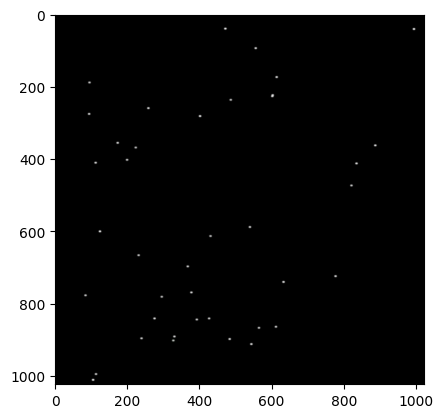

In [2]:
videofile = "ExampleVideos/synthetic40.mp4"

# Visualize the input
cap = cv2.VideoCapture(videofile)

# Get the first frame
ret, frame = cap.read()

plt.imshow(frame)

In [3]:
# Load groundtruth dataframe
df = utils.loadDataFrame("ExampleVideos/synthetic40.csv")

def compute_deltas(df_in):

    df = df_in.copy()

    # Compute delta_x and delta_y columns for each sperm id and frame
    for index, row in df.iterrows():
        if row['frame'] > 0:
            prev_row = df[(df['sperm'] == row['sperm']) & (df['frame'] == row['frame'] - 1)]
            if not prev_row.empty:
                df.at[index, 'delta_x'] = row['x'] - prev_row.iloc[0]['x']
                df.at[index, 'delta_y'] = row['y'] - prev_row.iloc[0]['y']
            else:
                df.at[index, 'delta_x'] = 0
                df.at[index, 'delta_y'] = 0
    else:
        df.at[index, 'delta_x'] = 0
        df.at[index, 'delta_y'] = 0

    return df

df = compute_deltas(df)

### Train movement predictor

In [4]:
win_size = 5
tar_size = 5

# Create sliding window forecast dataset

def create_sliding_window_dataset(df, window_size=5, target_size=5):
    X = []
    y = []

    for index, row in df.iterrows():
        if row['frame'] >= window_size:
            features = []
            for w in range(window_size):
                prev_row = df[(df['sperm'] == row['sperm']) & (df['frame'] == row['frame'] - w)]
                if not prev_row.empty:
                    features.extend([prev_row.iloc[0]['delta_x'], prev_row.iloc[0]['delta_y']])
                else:
                    features.extend([0, 0])
            X.append(features)
            outputs = []
            for t in range(target_size):
                out_row = df[(df['sperm'] == row['sperm']) & (df['frame'] == row['frame'] + t)]
                if not out_row.empty:
                    outputs.extend([out_row.iloc[0]['delta_x'], out_row.iloc[0]['delta_y']])
                else:
                    outputs.extend([0, 0])
            y.append(outputs)

    return np.array(X), np.array(y)

X, y = create_sliding_window_dataset(df, window_size=win_size, target_size=tar_size)

print(X.shape, y.shape) # Currently delta_x and delta_y are in the same dimension 

(10600, 10) (10600, 10)


In [5]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=5000)
model.fit(X, y)

MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=5000)

In [6]:
# Test set
test_df = utils.loadDataFrame("ExampleVideos/synthetic10.csv")
test_df = compute_deltas(test_df)
X_test, y_test = create_sliding_window_dataset(test_df, window_size=win_size, target_size=tar_size)
predictions = model.predict(X_test)

# Evaluate the model
mse = np.mean((predictions - y_test) ** 2)
print(f"Mean Squared Error on test set: {mse}")

Mean Squared Error on test set: 0.15527192312854912


### Visualize Predictor Performance

Sperm 36


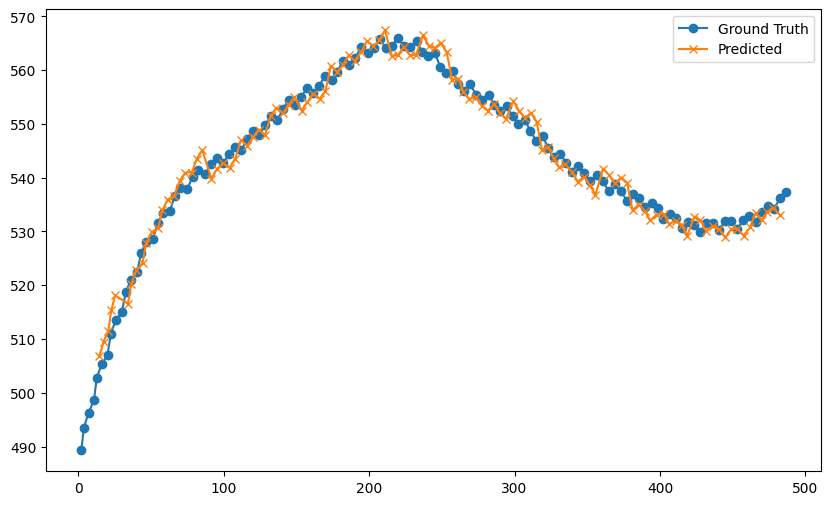

In [7]:
test_df = utils.loadDataFrame("ExampleVideos/synthetic10.csv")
test_df = compute_deltas(test_df)

#sperm_id = np.random.choice(test_df["sperm"].unique(), 1)[0]
sperm_id = 36
sperm = test_df[test_df["sperm"] == sperm_id]
# Get the sperm trajectory
sperm = sperm[["frame", "x", "y","delta_x","delta_y"]].to_numpy()

# Predict the trajectory in target_size chunks
window_size = win_size
target_size = tar_size
predicted_positions = []

for i in range(window_size, len(sperm) - target_size + 1, target_size):
    input_window = []
    for w in range(window_size):
        input_window.extend([sperm[i - w - 1][3], sperm[i - w - 1][4]])  # delta_x, delta_y
    input_window = np.array(input_window).reshape(1, -1)
    
    prediction = model.predict(input_window)[0]
    
    for t in range(target_size):
        if t == 0:
            last_x = sperm[i - 1][1]
            last_y = sperm[i - 1][2]
        pred_dx = prediction[2 * t]
        pred_dy = prediction[2 * t + 1]
        last_x += pred_dx
        last_y += pred_dy
        predicted_positions.append((last_x, last_y))

# Plot actual vs predicted
predicted_positions = np.array(predicted_positions)
print("Sperm", sperm_id)
plt.figure(figsize=(10, 6))
plt.plot(sperm[:, 1], sperm[:, 2], label="Ground Truth", marker='o')
plt.plot(predicted_positions[:, 0], predicted_positions[:, 1], label="Predicted", marker='x')
plt.legend()
plt.show()




### Create forecasting based tracker

In [14]:
# Start with perfect detections for now
test_df = utils.loadDataFrame("ExampleVideos/synthetic40.csv")
test_df = test_df.drop(columns=['sperm']) # Remove sperm ids

def forecast_tracker(df, model, window_size=5, target_size=5, dist_cutoff=20):

    # Make sperm ids column
    df = df.copy()
    df['sperm'] = -1  # Initialize sperm ids with -1
    next_sperm_id = 0

    # For the first frame, assign new ids to all detections
    first_frame_detections = df[df['frame'] == df['frame'].min()]   
    for index, det in first_frame_detections.iterrows():
        df.at[index, 'sperm'] = next_sperm_id
        next_sperm_id += 1

    # Look at all possible trajectories at the current frame
    for frame_num in range(df['frame'].min(), df['frame'].max()+1):
        frame_detections = df[df['frame'] == frame_num]

        for index, row in frame_detections.iterrows():

            sperm_id = row["sperm"]
            # If an undetected sperm exists at this point, add it to the list
            if sperm_id == -1:
                df.at[index, 'sperm'] = next_sperm_id
                next_sperm_id += 1
                continue

            # If the sperm id exists already in the next frame, skip it
            if sperm_id in df[df['frame'] == frame_num + 1]['sperm'].values:
                continue

            # Otherwise, grab its previous trajectory
            prev_traj = df[df["sperm"]==sperm_id]

            # If the length of prev trajectory is less than the window size, use a radius to make a prediction
            if len(prev_traj) < window_size:
                next_frame_num = frame_num + 1
                if next_frame_num > df['frame'].max():
                    break
                next_frame_detections = df[df['frame'] == next_frame_num]
                if next_frame_detections.empty:
                    continue
                
                last_row_curr = prev_traj[prev_traj['frame'] == frame_num]
                last_x = last_row_curr.iloc[0]['x']
                last_y = last_row_curr.iloc[0]['y']

                # Find the closest detection within the distance cutoff
                min_dist = float('inf')
                best_index = -1
                for det_index, det_row in next_frame_detections.iterrows():
                    dist = np.sqrt((det_row['x'] - last_x) ** 2 + (det_row['y'] - last_y) ** 2)
                    if dist < min_dist and dist < dist_cutoff and det_row['sperm'] == -1:
                        min_dist = dist
                        best_index = det_index

                # If a suitable detection is found, assign the sperm id
                if best_index != -1:
                    df.at[best_index, 'sperm'] = sperm_id

            # Otherwise, use the model to predict its next target_size positions
            else:
                input_window = []
                for w in range(window_size):
                    prev_row = prev_traj[prev_traj['frame'] == frame_num - w - 1]
                    if prev_row.empty:
                        input_window.extend([0, 0])
                    else:
                        input_window.extend([row['x']-prev_row.iloc[0]['x'], row['y']-prev_row.iloc[0]['y']]) # Compute deltas
                input_window = np.array(input_window).reshape(1, -1)

                prediction = model.predict(input_window)[0]

                # Get the predicted position after each step
                predicted_positions = []
                last_x = prev_traj[prev_traj['frame'] == frame_num].iloc[0]['x']
                last_y = prev_traj[prev_traj['frame'] == frame_num].iloc[0]['y']
                for t in range(target_size):
                    pred_dx = prediction[2 * t]
                    pred_dy = prediction[2 * t + 1]
                    last_x += pred_dx
                    last_y += pred_dy
                    predicted_positions.append((last_x, last_y))

                # Now associate the predicted positions with the detections in the next target_size frames
                for t in range(target_size):
                    next_frame_num = frame_num + t

                    if next_frame_num > df['frame'].max():
                        break

                    next_frame_detections = df[df['frame'] == next_frame_num]
                    if next_frame_detections.empty:
                        continue

                    pred_x, pred_y = predicted_positions[t]

                    # Find the closest detection within the distance cutoff
                    min_dist = float('inf')
                    best_index = -1
                    for det_index, det_row in next_frame_detections.iterrows():
                        dist = np.sqrt((det_row['x'] - pred_x) ** 2 + (det_row['y'] - pred_y) ** 2)
                        if dist < min_dist and dist < dist_cutoff and det_row['sperm'] == -1:
                            min_dist = dist
                            best_index = det_index

                    # If a suitable detection is found, assign the sperm id
                    if best_index != -1:
                        df.at[best_index, 'sperm'] = sperm_id

    return df

tracked_df = forecast_tracker(test_df, model, window_size=win_size, target_size=tar_size)
print(tracked_df)

       frame           x           y  sperm
0          0  601.327884  227.549626      0
1          0  275.155018  842.617008      1
2          0  426.934511  842.819802      2
3          0  377.818236  770.007042      3
4          0  776.761917  725.331055      4
...      ...         ...         ...    ...
10795    269  698.867675  958.793516   4026
10796    269  649.223149  970.689892   4027
10797    269   64.072175  590.725437   4028
10798    269    3.995669   75.673208      1
10799    269  227.147963    5.661007   4029

[10800 rows x 4 columns]


In [15]:
# Plot tracks
videofile = "ExampleVideos/synthetic40.mp4"
visualizer.runVisualization(videofile, tracked_df)

(4030, 3)
Video Finished.
